# Concept Network Tool

## Import data

Here user has to define the following:

- `DATA_PATH`: the folder including data files
- `DATA_FILES` : automatically detected `csv` files from `DATA_PATH` 


In [1]:
# Load R packages
pacman::p_load(tidyverse, udpipe, stopwords, igraph, ggraph, textrank, textreuse)

In [2]:
DATA_PATH <- "processed_data"
DATA_FILES <- list.files(DATA_PATH, pattern = ".csv",full.names = TRUE,)

cat("Available datasets in", DATA_PATH, "\n",
    
    paste(paste(1:length(DATA_FILES) ,"\t", DATA_FILES, "\n"), sep = "\n"), "\n")


df_path <- DATA_FILES[as.numeric(readline(prompt="Select data: "))]
df_raw <- read.csv(df_path)
cat(df_path, "selected.")

Available datasets in processed_data 
 1 	 processed_data/hs2014_processed.csv 
 
Select data: 1
processed_data/hs2014_processed.csv selected.

## Stopword removal

R package [`stopwords`](https://cran.r-project.org/web/packages/stopwords/readme/README.html) includes three Finnish stop word lists: 

    1. nltk
    2. snowball
    3. stopwords-iso


Then filter the data by excluding words from the stop word list.

In [3]:
sw_lists_available <- sort(stopwords_getsources()[unlist(lapply(stopwords_getsources(), function(x) ifelse("fi" %in% stopwords_getlanguages(x), TRUE, FALSE)))])
sw_lists <- c(lapply(sw_lists_available, function(y) stopwords("fi", y)), list(NA))
sw_list_sizes <- lapply(sw_lists, function(z) ifelse(length(z) > 1, length(z), 0))
                
sw_options <- c(paste(c(sw_lists_available, "None"), paste0("(", sw_list_sizes, " words)")), "Custom")
                        
cat("Stopword lists available:\n",paste(paste(1:length(sw_options) ,"\t", sw_options, "\n"), sep = "\n"), "\n")

sw_selection <- readline(prompt="Select stopword list: ")                        

if(as.numeric(sw_selection) == length(sw_options)) {
    custom_stopwords <- readline(prompt="List all stopwords. Separate with a comma.\n")
    stopword_list <- trimws(stringr::str_split(custom_stopwords, ",", simplify = TRUE), "both")
    cat(length(stopword_list), "stopwords saved.")
} else {
    stopword_list <- sw_lists[[as.numeric(sw_selection)]]
    cat("Stopwords:\n", paste(stopword_list, collapse = ", "), sep ="")
}
                        
                     

Stopword lists available:
 1 	 nltk (229 words) 
 2 	 snowball (68 words) 
 3 	 stopwords-iso (847 words) 
 4 	 None (0 words) 
 5 	 Custom 
 
Select stopword list: 4
Stopwords:
NA

In [5]:
# Remove all the stop words above from the data
df <- df_raw %>%
  filter(!lemma %in% stopword_list) 

# Concept extraction

## Word co-occurrences 

In [6]:
cooc_all <- cooccurrence(x = df$lemma, 
                     relevant = df$upos %in% c("NOUN", "ADJ"))

wn_all <- graph_from_data_frame(cooc_all)

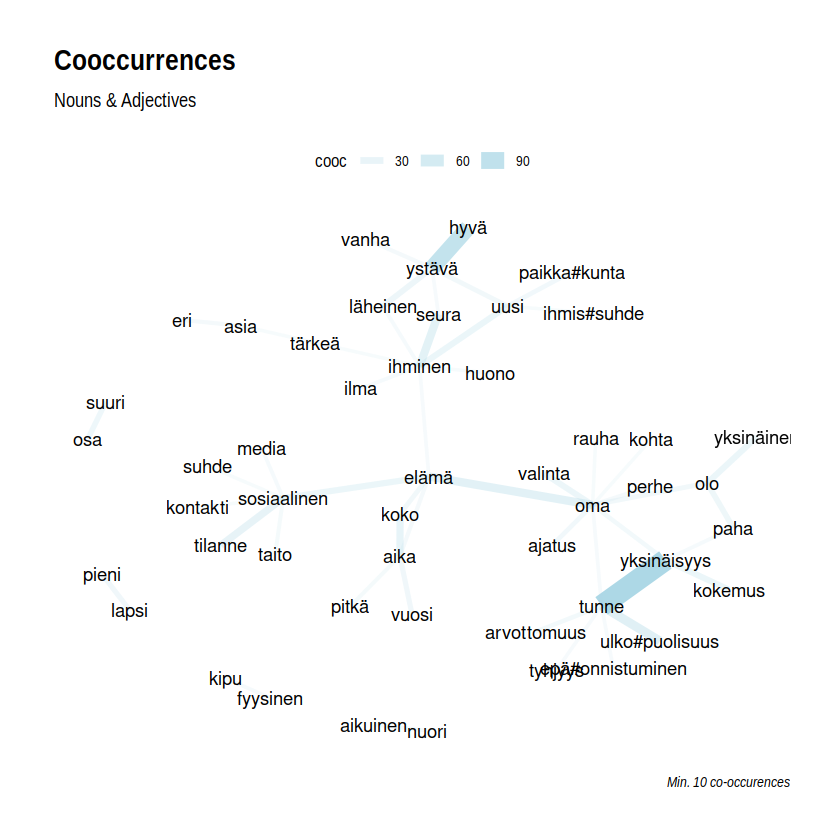

In [7]:
set.seed(166)

subset(cooc_all, cooc >= 10) %>%
graph_from_data_frame() %>%ggraph(layout = "fr") +
  geom_edge_link(aes(width = cooc, edge_alpha = cooc), edge_colour = "lightblue") +
  geom_node_text(aes(label = name)) +
  theme_graph() +
  theme(legend.position = "top") +
  labs(title = "Cooccurrences", 
       subtitle = "Nouns & Adjectives", 
       caption = "Min. 10 co-occurences")

## Word co-occurences in context windows

In [8]:
cooc_context <- cooccurrence(x = df$lemma, 
                     relevant = df$upos %in% c("NOUN", "ADJ"), 
                      skipgram = 2)

wn_context <- graph_from_data_frame(cooc_context)

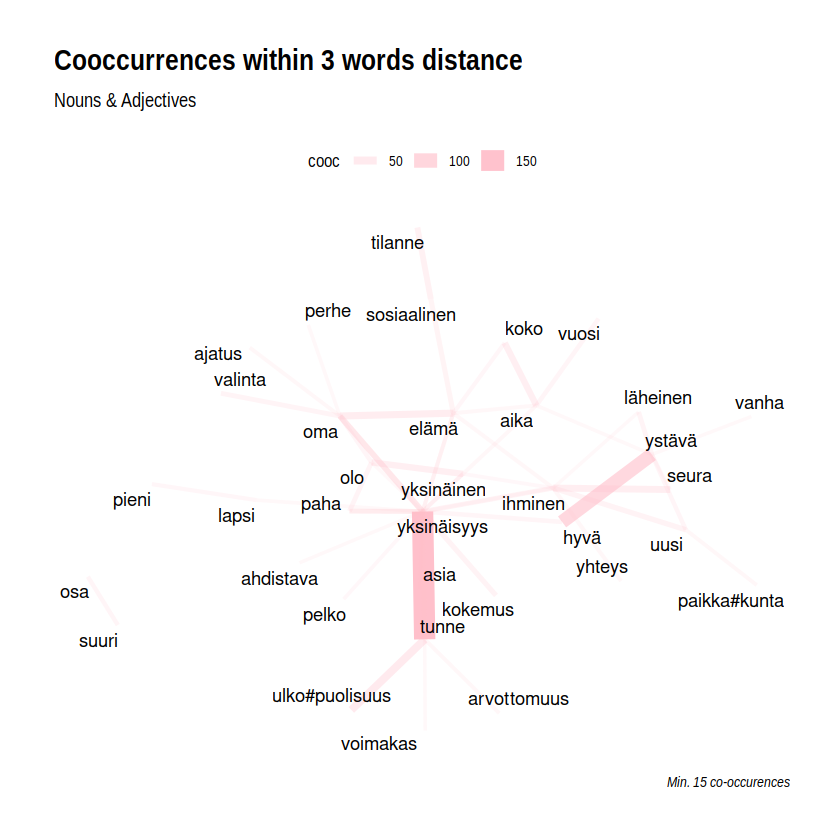

In [9]:
set.seed(155)

subset(cooc_context, cooc >= 15) %>%
graph_from_data_frame() %>%
ggraph(layout = "fr") +
  geom_edge_link(aes(width = cooc, edge_alpha = cooc), edge_colour = "pink") +
  geom_node_text(aes(label = name), repel = TRUE) +
  theme_graph() +
  theme(legend.position = "top") +
  labs(title = "Cooccurrences within 3 words distance", 
       subtitle = "Nouns & Adjectives",
       caption = "Min. 15 co-occurences")

## Textrank

In [53]:
keyw <- textrank_keywords(df %>% mutate(lemma = str_replace_all(lemma, "#", "")) %>% pull(lemma) ,
                          relevant = df$upos %in% c("NOUN", "VERB", "ADJ"))

concept_data <- keyw$keywords %>% 
    filter(ngram > 1 & freq > 1) %>% 
    mutate(word2 = strsplit(keyword, "-")) %>% 
    unnest(word2) %>%
    group_by(keyword) %>%
    mutate(word1 = lag(word2)) %>%
    relocate(word1, .before = word2) %>%
    ungroup() %>%
    filter(!is.na(word1))

vocab <- unique(c(concept_data$word1, concept_data$word2))

textrank_data <- data.frame(pagerank = keyw$pagerank$vector) %>%
    rownames_to_column("lemma") 


## Functions

In [68]:
get_concepts <- function(data, concept) {
    
    if(str_detect(concept, ",")){
        concept <- str_extract_all(concept, pattern = "\\w+") %>% 
        unlist()
        
        cat("Displaying results including following concepts:", "\n",
            paste(paste(1:length(concept) ,"\t", concept, "\n"), sep = "\n"), "\n")
    }
    
    concept_keywords <- data %>% 
        filter(word1 %in% concept)  %>%
        pull(keyword)

    vocab <- unique(c(concept_data$word1, concept_data$word2))
    
    all_concepts <- data %>% 
        filter(keyword %in% concept_keywords)
    
    return(all_concepts)
}

get_edges <- function(data, concept, threshold = NULL) {
    df <-  data %>%
    get_concepts(concept = concept) %>%
    select(word1, word2, freq) %>%
    group_by(word1,word2) %>%
    summarize(n = sum(freq), .groups = "drop") %>%
    rename(from = word1,
          to = word2)
    
    if(!is.null(threshold)) {
        df <- df %>% filter(n >= threshold)
    }
    
    return(df)
} 

get_nodes <- function(data, vocab) {
    df <- data %>% filter(lemma %in% vocab)
    
    return(df)
}

plot_graph <- function(edges, nodes, concepts, ...) {  
    
nodes <- nodes %>%
    mutate(is_concept = factor(ifelse(lemma %in% concepts, 1, 0), levels = 0:1, labels = c("Concept word", "Regular word")))

p <- graph_from_data_frame(edges, directed = FALSE, vertices = nodes) %>%
    ggraph(layout = "kk") +
    geom_edge_link(aes(width = n, edge_alpha = n), edge_colour = "lightblue") +
    geom_node_point(aes(size = pagerank)) +
    geom_node_text(aes(label = name, col = is_concept), check_overlap = TRUE, repel = TRUE) +
    scale_color_manual("", values = c("black","red")) +
    theme_graph() +
    labs(
        title = "Textrank extracted keyword occurences",
        subtitle = "Adjectives, Nouns, Verbs",
         ... ) +
    theme(legend.position = "right")    

return(p)
}

### Interactive

Enter word:ihminen


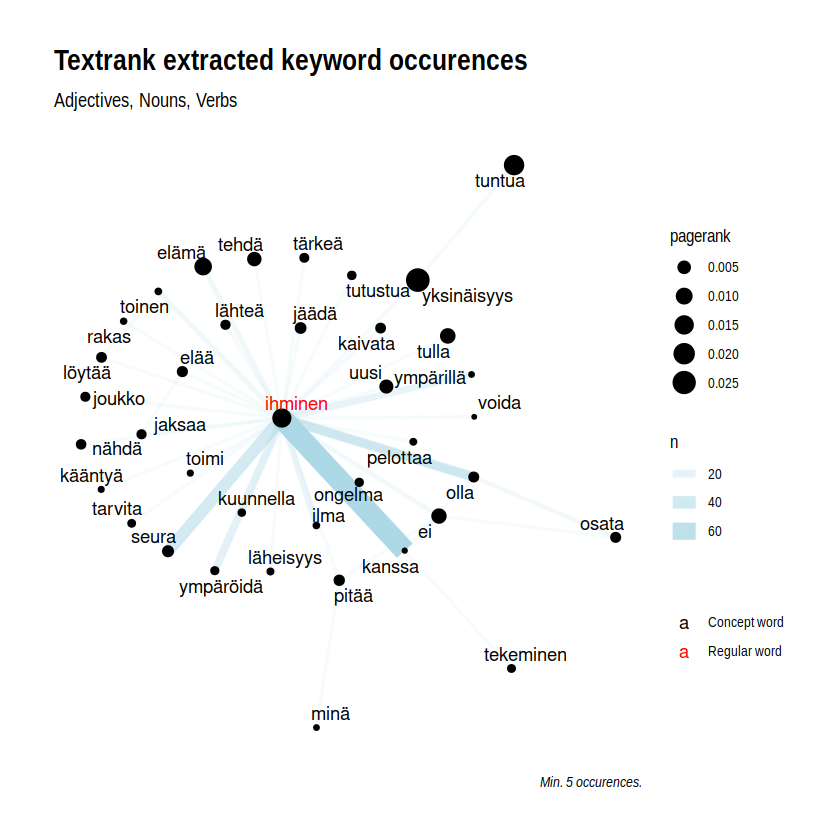

In [74]:
query <- tolower(readline(prompt="Enter word:"))

while(TRUE) {
   valid_word = query %in% vocab
    
    if(tolower(query) == "c"){
        interactive_status <- FALSE
        cat("Stopping.")
        break
    }
    
    if(valid_word != TRUE) {
        query <- tolower(readline(prompt="Word not in vocabulary. Enter another word: (or C to stop)"))

    } else {
        interactive_status <- TRUE
        break
    }
}


if(interactive_status == TRUE) {

    threshold = 5

    edges <- get_edges(concept_data, concept = query, threshold = NULL)
    concept_vocab <- unique(c(edges$from, edges$to))
    nodes <- get_nodes(textrank_data, vocab = concept_vocab)    

    plot_graph(edges, nodes, concept = query, caption = paste("Min.", threshold, "occurences."))

}


## Multiconcept Textrank


Enter words (separated by a comma):Yksinäisyys, tunne, tuntea
Displaying results including following concepts: 
 1 	 yksinäisyys 
 2 	 tunne 
 3 	 tuntea 
 


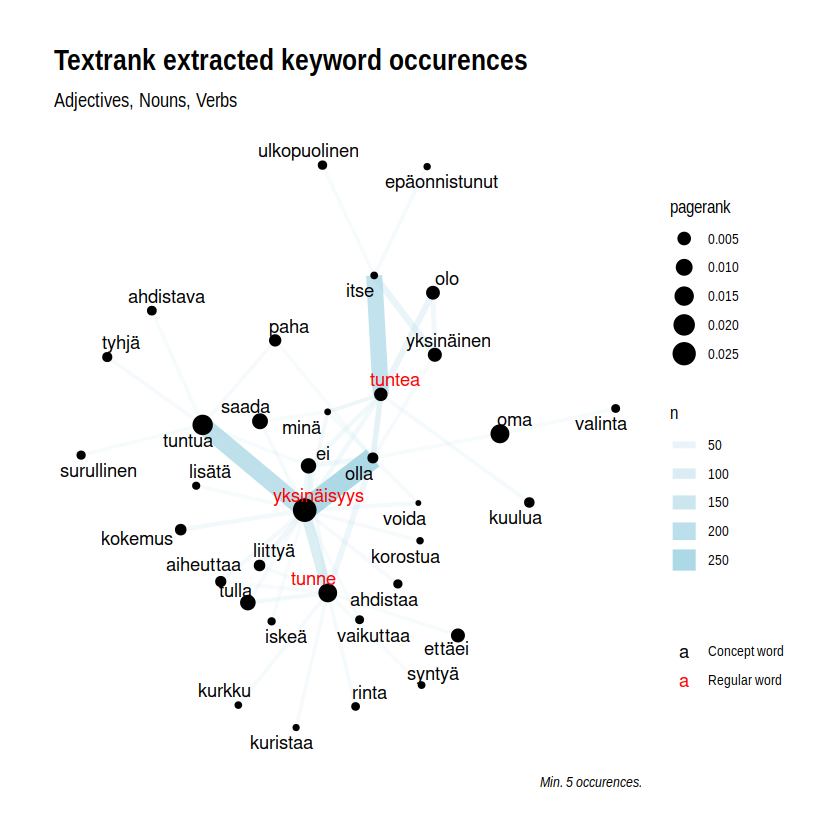

In [75]:
query <- tolower(readline(prompt="Enter words (separated by a comma):"))

query_list <- str_extract_all(query, pattern = "\\w+") %>% unlist()

# fix query

while(TRUE) {
   valid_words = query_list %in% vocab
    
    if(tolower(query) == "c"){
        interactive_status <- FALSE
        cat("Stopping.")
        break
    }
    

    
    if(any(valid_words != TRUE)){
        
        cat("Following words not found in vocabulary:", paste(query_list[!valid_words], collapse = ", "), "\n")
        flush.console()
        
        query <- tolower(readline(prompt="Re-enter words: (or C to stop)"))
        query_list <- str_extract_all(query, pattern = "\\w+") %>% unlist()
        
    } 
    
    if(all(valid_words) == TRUE){
        interactive_status <- TRUE
        break
    }
}


if(interactive_status == TRUE) {

    threshold <- 5
    
    edges <- get_edges(concept_data, concept = query, threshold = threshold)
    concept_vocab <- unique(c(edges$from, edges$to))
    nodes <- get_nodes(textrank_data, vocab = concept_vocab)    
    plot_graph(edges, nodes, concepts = query_list, caption = paste("Min.", threshold, "occurences."))
}